# Global Summit 2022 - Tech Exchange demo

This notebook shows a few more queries run against a 1B row dataset on a beefy server in our Cambridge, MA headquarters. Most of these correspond to the ones in the additional demo presented by Tom Woodfin at the Tech Exchange on Thursday afternoon at Global Summit 2022. The point of these is that they help you appreciate how the high performance for analytical queries brought by Columnar Storage enables users to have an almost interactive conversation with the data, without having to wait minutes between hitting the Run button and seeing a result.

In [1]:
# dull imports and utility methods - you can skip right through!

import iris, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

connection = iris.connect("colobench3:51779/NYTAXI1B", "_SYSTEM", "SYS")

import warnings
warnings.simplefilter("ignore")

# utility vars and function to compare metrics
history = { "time": {}, "grefs": {}, "logical": {}, "physical": {} }
plans = []

def reset_compare():
    global history
    history = { "time": {}, "grefs": {}, "logical": {}, "physical": {} }

def brag(prev, new, speed=True):
    if ((prev == 0) or (new == 0) or (prev == new)):
        return ""
    if (prev > new):
        rate = prev / new
        if (rate > 20):
            return " - {:,.0f}x {}".format(rate, "faster" if speed else "less")
        elif (rate > 2):
            return " - {:,.2f}x {}".format(rate, "faster" if speed else "less")
        else:
            return " - {:,.0%} {}".format(rate-1, "faster" if speed else "less")
    else:
        rate = new / prev
        if (rate > 20):
            return " - {:,.0f}x {}".format(rate, "slower" if speed else "more")
        elif (rate > 2):
            return " - {:,.2f}x {}".format(rate, "slower" if speed else "more")
        else:
            return " - {:,.0%} {}".format(rate-1, "slower" if speed else "more")
        
def just_sql(sql):
    c1 = connection.cursor()
    c1.execute(sql)
    result = c1.fetchall()[0]
    c1.close()
    return result

def run_often(sql, times=10):
    for i in range(times):
        x = just_sql(sql)

def query(sql, compare = None, dtypes = None):
    global plans, history
    
    plans.append(just_sql("EXPLAIN "+sql)[0])
    
    start_grefs, start_logical, start_physical = just_sql("SELECT NYTaxi.GloRefs(), NYTaxi.LogicalBytes(), NYTaxi.PhysicalBytes()")
    
    start_time = time.time()
    result = pd.read_sql_query(sql, connection, dtype = dtypes)
    exec_time = time.time() - start_time
    
    end_grefs, end_logical, end_physical = just_sql("SELECT NYTaxi.GloRefs(), NYTaxi.LogicalBytes(), NYTaxi.PhysicalBytes()")
    exec_grefs = end_grefs - start_grefs - 1
    exec_logical = end_logical - start_logical
    exec_physical = end_physical - start_physical
    
    print("\nExecution time: {:.3f}s\nGlobal references: {:,}\nBytes read: {:,} kB ({:,} kB physical)".format(exec_time, exec_grefs, exec_logical, exec_physical))
    # print("\nExecution time: {:.3f}s\nGlobal references: {:,}".format(exec_time, exec_grefs, exec_logical, exec_physical))
    
    if compare is not None:
        #print("\nExecution time: {:.3f}s ".format(exec_time) + brag(last_time, exec_time))
        #print("Global references: {:,} ".format(exec_grefs) + brag(last_grefs, exec_grefs, False))
        history['time'][compare] = exec_time
        history['grefs'][compare] = exec_grefs
        history['logical'][compare] = exec_logical
        history['physical'][compare] = exec_physical
        #if len(history['time'].keys())>=2:
        #    plot_compare()
    
    return result

def plot_compare():
    global history
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))
    fig.suptitle('Query Performance Comparison', y=1.05, size=15)

    b1 = ax1.bar(history['time'].keys(), history['time'].values(), color=['tab:blue','tab:orange','tab:green'])
    ax1.set_title("Execution time", pad=10)
    ax1.bar_label(b1, fmt='%.2fs')
    ax1.set_ylim(top=(max(history['time'].values())*1.1))
    v1 = list(history['time'].values())
    if len(v1)==3:
        ax1.annotate(brag(v1[0],v1[1])[3:].replace(' ','\n'), 
                     (0.5, 0.7), xycoords='axes fraction',
                     ha='center', va="bottom")
        ax1.annotate(brag(v1[1],v1[2])[3:].replace(' ','\n'), 
                     (0.84, 0.4), xycoords='axes fraction',
                     ha='center', va="bottom", 
                     size=15, fontweight="bold")
    else:
        ax1.annotate(brag(v1[len(v1)-2],v1[len(v1)-1])[3:].replace(' ','\n'), 
                     (0.75, 0.5), xycoords='axes fraction',
                     ha='center', va="bottom", 
                     size=15, fontweight="bold")

    b2 = ax2.bar(history['grefs'].keys(), history['grefs'].values(), color=['tab:blue','tab:orange','tab:green'])
    ax2.set_title("IO (grefs)", pad=10)
    ax2.bar_label(b2, fmt='%d')
    ax2.set_ylim(top=(max(history['grefs'].values())*1.1))
    v2 = list(history['grefs'].values())
    if len(v2)==3:
        ax2.annotate(brag(v2[0],v2[1],False)[3:].replace(' ','\n'), 
                     (0.5, 0.7), xycoords='axes fraction',
                     ha='center', va="bottom")
        ax2.annotate(brag(v2[1],v2[2],False)[3:].replace(' ','\n'), 
                     (0.84, 0.4), xycoords='axes fraction',
                     ha='center', va='bottom',
                     size=15, fontweight="bold")
    else:
        ax2.annotate(brag(v2[len(v2)-2],v2[len(v2)-1],False)[3:].replace(' ','\n'), 
                     (0.75, 0.5), xycoords='axes fraction',
                     ha='center', va='bottom',
                     size=15, fontweight="bold")
    
    b3 = ax3.bar(history['logical'].keys(), history['logical'].values(), color=['tab:blue','tab:orange','tab:green'])
    ax3.set_title("Logical reads", pad=10)
    ax3.bar_label(b3, fmt='%d kB')
    ax3.set_ylim(top=(max(history['logical'].values())*1.1))
    v3 = list(history['logical'].values())
    if len(v3)==3:
        ax3.annotate(brag(v3[0],v3[1],False)[3:].replace(' ','\n'), 
                     (0.5, 0.7), xycoords='axes fraction',
                     ha='center', va="bottom")
        ax3.annotate(brag(v3[1],v3[2],False)[3:].replace(' ','\n'), 
                     (0.84, 0.4), xycoords='axes fraction',
                     ha='center', va='bottom',
                     size=15, fontweight="bold")
    else:
        ax3.annotate(brag(v3[len(v3)-2],v3[len(v3)-1],False)[3:].replace(' ','\n'), 
                     (0.75, 0.5), xycoords='axes fraction',
                     ha='center', va='bottom',
                     size=15, fontweight="bold")

## Time to scale up to 1B!

```sql
SELECT COUNT(*) FROM NYTaxi
```

In [2]:
query("SELECT COUNT(*) FROM NYTaxi")


Execution time: 0.375s
Global references: 17,856
Bytes read: 36,936 kB (400 kB physical)


,Aggregate_1
0,1142317520


## That more complex query

```sql
SELECT Zone, Borough, Tip 
  FROM (
        SELECT TOP 10 PULocationID, AVG(tip_amount / fare_amount) AS Tip
          FROM NYTaxi.Rides24M
         WHERE fare_amount > 0
      GROUP BY PULocationID
      ORDER BY 2 DESC
        ) r 
        LEFT OUTER JOIN NYTaxi.Zones z ON r.PULocationID = z.LocationID
```


Execution time: 15.233s
Global references: 71,723
Bytes read: 21,686,752 kB (20,961,128 kB physical)


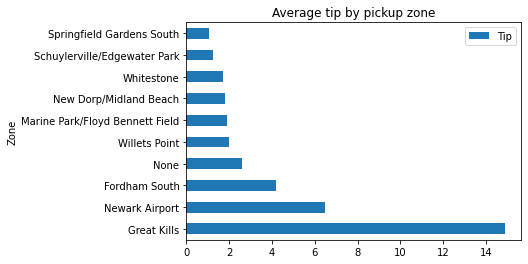

In [3]:
r = query("SELECT Zone, Borough, Tip FROM (SELECT TOP 10 PULocationID, AVG(tip_amount / fare_amount) AS Tip FROM %PARALLEL NYTaxi WHERE fare_amount > 0 GROUP BY PULocationID ORDER BY 2 DESC) r LEFT JOIN NYTaxi.Zones z ON r.PULocationID = z.LocationID", dtypes = { "Tip": np.double }, compare="row")
r.plot.barh(x="Zone", y="Tip", title="Average tip by pickup zone");

## Short trips in Soho

```sql
 SELECT AVG(tip_amount) 
   FROM NYTaxi 
  WHERE passenger_count > 1 
        AND trip_distance < 1 
        AND PULocationId = (SELECT LocationId 
                              FROM NYTaxi.Zones 
                             WHERE zone = 'SoHo')
```

In [4]:
query("select avg(tip_amount) from NYTaxi where passenger_count > 1 and trip_distance < 1 and PULocationId = (select LocationId from NYTaxi.Zones where zone = 'SoHo')")


Execution time: 6.672s
Global references: 89,443
Bytes read: 23,055,752 kB (10,552,616 kB physical)


,Aggregate_1
0,0.790574


In [5]:
print(plans[-1])

<plans>
 <plan>
 <sql>
  select avg(tip_amount) from NYTaxi where passenger_count > 1 and trip_distance < 1 and PULocationId = (select LocationId from NYTaxi.Zones where zone = 'SoHo') /*#OPTIONS {"xDBCIsoLevel":"0"} */
 </sql>
 <cost value=""/>
 Call module C.
 From each parallel process:
     Accumulate the count([value]).
     Accumulate the sum([value]).
 <module name="C" top="1">
 Partition extent bitmap SQLUser.NYTaxi.%%DDLBEIndex, and in parallel, for each partition, looping on bitmap chunks.
 For each bitmap chunk:
     Read columnar index SQLUser.NYTaxi._CDM_PULocationID, using the given chunk number.
     Apply vector operation = to produce a filter.
     Read columnar index SQLUser.NYTaxi._CDM_tripdistance, using the given chunk number.
     Apply vector and bitmap operations < and & to produce a filter.
     Read columnar index SQLUser.NYTaxi._CDM_passengercount, using the given chunk number.
     Apply vector and bitmap operations >, &, defined, &, defined, and & to produc

## Big Tippers

```sql
 SELECT count(*) 
   FROM NYTaxi 
  WHERE tip_amount >= total_amount * .2
```

In [6]:
query("select count(*) from NYTaxi where tip_amount >= total_amount * .2")


Execution time: 6.419s
Global references: 53,553
Bytes read: 19,058,016 kB (9,271,616 kB physical)


,Aggregate_1
0,78146772


## Tips by passenger count

```sql
 SELECT passenger_count, 
        AVG(tip_amount / fare_amount) AS TipByFare, 
        COUNT(*) 
   FROM NYTaxi 
  WHERE trip_distance < 100 
          AND trip_distance > 0 
          AND fare_amount > 0 
          AND passenger_count < 10 
GROUP BY passenger_count
```


Execution time: 3.639s
Global references: 89,237
Bytes read: 29,914,168 kB (80 kB physical)


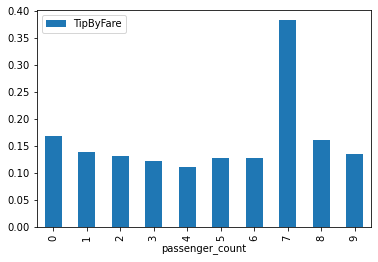

In [7]:
r = query("SELECT passenger_count, AVG(tip_amount / fare_amount) AS TipByFare, COUNT(*) FROM NYTaxi WHERE trip_distance < 100 and trip_distance > 0 and fare_amount > 0 and passenger_count < 10 GROUP BY passenger_count")
r.plot.bar(x="passenger_count", y="TipByFare");